In [1]:
using IMinuit, QuadGK, NLsolve
using CSV, DataFrames, LaTeXStrings; ENV["COLUMNS"]=160
import PyPlot
using Plots; pyplot(frame=:box, minorticks=5, size=(500,350)) 
using BenchmarkTools;
PyPlot.matplotlib.rc("mathtext", fontset="cm")      
PyPlot.matplotlib.rc("font", family="serif", size=11) 

In [2]:
include("quadgauss.jl");
include("hadronmasses.jl");

In [3]:
λ(a,b,c) = a^2+b^2+c^2-2a*b-2b*c-2a*c

function qsq(E,m1,m2) 
    return λ(E^2,m1^2,m2^2)/(4E^2)
end

# 2-body phase space factor
phsp(E,m1,m2) = sqrt(qsq(E,m1,m2))/(8π*E);

In [4]:
# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end

ρ(w,m1,m2) = xsqrt(qsq(w,m1,m2)+0im)/(8π*w);

In [5]:
# two-point loop function from dim. reg. with a subtraction constant
function Gdr(w, m1, m2, a=-3)
    μ = 1.0; s = w^2; Δ = m1^2-m2^2
	qcm = xsqrt(λ(s, m1^2, m2^2)+0im)/(2w)
    return @fastmath 1/(16π^2) * (a + 2log(m1/μ) + 2(m2^2-m1^2+s)/(2s)*log(m2/m1) + qcm/w *
    (log(s-Δ+2qcm*w) + log(s+Δ+2qcm*w) - log(-s+Δ+2qcm*w) - log(-s-Δ+2qcm*w) ) )
end

Gdr (generic function with 2 methods)

In [6]:
# read parameters from file, and parse strings into tuples for the parameter sets
function read_file(file::String; cols=(:lecs_init, :lecs_final))
    df = DataFrame!(CSV.File(file))
    for col in cols
        df[col] = map(x->eval(Meta.parse(x)), df[col])
    end
    return df
end

read_file (generic function with 1 method)

The residues of the amplitude $T_{ij}$ at pole $E_0$ is calculated via
\begin{equation}
{\rm Res}(T_{ij})=\lim_{E\to E_0} (E^2-E_0^2)T_{ij}(E)
\end{equation}

### 2-channel

In [7]:
# T matrix elements (T11, T12, T22) in 4 Riemann sheets, default to the 1st sheet
function T(w, par, rs::Integer=1)
    a1, a2, c, b1, b2 = par
    
    v11 = (a1 + b1*qsq(w, mjψ, mjψ)) * 4mjψ^2
    v22 = (a2 + b2*qsq(w, mψp, mjψ)) * 4mjψ*mψp
    v12 = c * 4mjψ*sqrt(mjψ*mψp)
    v21 = v12

    g11 = Gdr(w, mjψ, mjψ)
    g22 = Gdr(w, mψp, mjψ)
    
    if rs == 1
        nothing
    elseif rs == 2
        g11 += 2im *ρ(w,mjψ,mjψ)
    elseif rs == 3
        g11 += 2im *ρ(w,mjψ,mjψ)
        g22 += 2im *ρ(w,mψp,mjψ)
    elseif rs == 4
        g22 += 2im *ρ(w,mψp,mjψ)
    else
        error("rs should be 1, 2, 3 or 4.")
    end
    
    num11 = -g22*v11*v22 + g22*v12^2 + v11
    num12 = v12
    num22 = g11*(v12^2-v11*v22) + v22
    den = 1 - g11*num11 - g22*v22
    
    return (num11/den, num12/den, num22/den)
end

T (generic function with 2 methods)

In [8]:
polesdf_2c = read_file("data/poles_2c.csv", cols=(:pole_rs1, :pole_rs2_low, :pole_rs2_high, :pole_rs3));
parametersets_2c = DataFrame!(CSV.File("data/parametersets_2c.csv"));

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = read_file(::String; cols::NTuple{4,Symbol}) at In[6]:5
└ @ Main .\In[6]:5
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = read_file(::String; cols::NTuple{4,Symbol}) at In[6]:5
└ @ Main .\In[6]:5


In [9]:
res_df_2c= DataFrame(rs1=Real[], rs2_low=Real[], rs2_high=Real[], rs3=Real[]) 
for i=1:nrow(parametersets_2c)
    restem=Vector(undef,4)
    rss=(1,2,2,3)
    for j=1:4
        #different Riemann sheets
        w0=polesdf_2c[i,j]
        resfun(w)=sqrt(abs(T(w,parametersets_2c[i,2:6],rss[j])[1]*(w^2-w0^2)))
        res7=resfun(w0-10E-7)
        res8=resfun(w0-10E-8)
        #shows the residue and relative error between 10E-8 and 10E-7
        restem[j]= res8
    end
    push!(res_df_2c, restem)
end  

In [10]:
lower = polesdf_2c[2];
higher = polesdf_2c[real.(polesdf_2c.pole_rs2_high) .>6.25, 3];
pole1 = polesdf_2c[(real.(polesdf_2c.pole_rs1)) .>0, 1];
pole3 = polesdf_2c[4];

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[10]:1
└ @ Core In[10]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[10]:4
└ @ Core In[10]:4


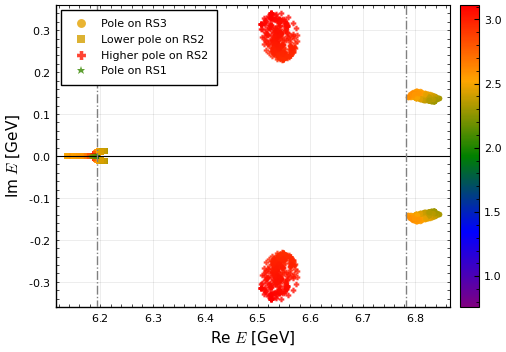

In [11]:
scatter(real.(pole3), imag.(pole3),zcolor=log.(abs.(res_df_2c.rs3)),m = (:circle,:rainbow, 0.8, Plots.stroke(0, :green)), label="Pole on RS3")
scatter!(real.(pole3), -imag.(pole3),zcolor=log.(abs.(res_df_2c.rs3)),m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)),label=false  )
scatter!(real.(lower), imag.(lower), zcolor=log.(abs.(res_df_2c.rs2_low)),m = (:rect,:rainbow, 0.8,Plots.stroke(0, :green)), label="Lower pole on RS2", alpha=0.8 )
scatter!(real.(lower), -imag.(lower),zcolor=log.(abs.(res_df_2c.rs2_low)),m = (:rect,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label=false  )
scatter!(real.(higher), imag.(higher), zcolor=log.(abs.(res_df_2c[real.(polesdf_2c.pole_rs2_high) .>6.25,3])),m = (:cross,:rainbow, 0.8,Plots.stroke(0, :green)), label="Higher pole on RS2"  )   
scatter!(real.(higher), -imag.(higher), zcolor=log.(abs.(res_df_2c[real.(polesdf_2c.pole_rs2_high) .>6.25,3])),m = (:cross,:rainbow, 0.8,Plots.stroke(0, :green)),label=false )
scatter!(real.(pole1), imag.(pole1), zcolor=log.(abs.(res_df_2c[res_df_2c.rs1.>0,1])),m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)), label="Pole on RS1", alpha=0.8, marker="*" )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp], c = "gray",linestyle=:dashdot,label=false)
xlabel!("Re "*L"E"*" [GeV]"); ylabel!("Im "*L"E"*" [GeV]");
savefig("poles_residue_2c_log.pdf")

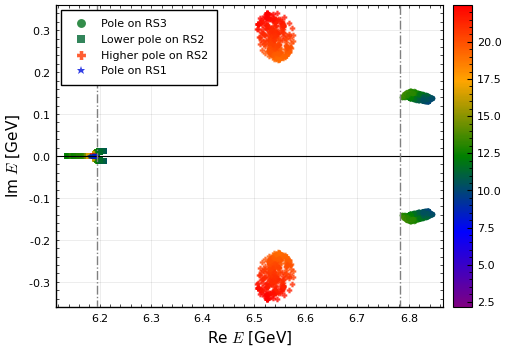

In [12]:
scatter(real.(pole3), imag.(pole3),zcolor=abs.(res_df_2c.rs3),m = (:circle,:rainbow, 0.8, Plots.stroke(0, :green)), label="Pole on RS3")
scatter!(real.(pole3), -imag.(pole3),zcolor=abs.(res_df_2c.rs3),m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)),label=false  )
scatter!(real.(lower), imag.(lower), zcolor=abs.(res_df_2c.rs2_low),m = (:rect,:rainbow, 0.8,Plots.stroke(0, :green)), label="Lower pole on RS2", alpha=0.8 )
scatter!(real.(lower), -imag.(lower),zcolor=abs.(res_df_2c.rs2_low),m = (:rect,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label=false  )
scatter!(real.(higher), imag.(higher), zcolor=abs.(res_df_2c[real.(polesdf_2c.pole_rs2_high) .>6.25,3]),m = (:cross,:rainbow, 0.8,Plots.stroke(0, :green)), label="Higher pole on RS2"  )   
scatter!(real.(higher), -imag.(higher), zcolor=abs.(res_df_2c[real.(polesdf_2c.pole_rs2_high) .>6.25,3]),m = (:cross,:rainbow, 0.8,Plots.stroke(0, :green)),label=false )
scatter!(real.(pole1), imag.(pole1), zcolor=abs.(res_df_2c[res_df_2c.rs1.>0,1]),m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)), label="Pole on RS1", alpha=0.8, marker="*" )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp], c = "gray",linestyle=:dashdot,label=false)
xlabel!("Re "*L"E"*" [GeV]"); ylabel!("Im "*L"E"*" [GeV]")
savefig("poles_residue_2c.pdf")

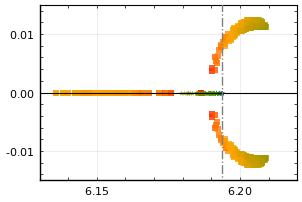

In [13]:
scatter(real.(pole3), imag.(pole3),zcolor=log.(abs.(res_df_2c.rs3)),m = (:circle,:rainbow, 0.8, Plots.stroke(0, :green)),label=false,size=(300,200),legend=false)
scatter!(real.(pole3), -imag.(pole3),zcolor=log.(abs.(res_df_2c.rs3)),m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)),label=false  )
scatter!(real.(lower), imag.(lower), zcolor=log.(abs.(res_df_2c.rs2_low)),m = (:rect,:rainbow, 0.8,Plots.stroke(0, :green)), label="Lower pole on RS2", alpha=0.8 )
scatter!(real.(lower), -imag.(lower),zcolor=log.(abs.(res_df_2c.rs2_low)),m = (:rect,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label=false  )
scatter!(real.(higher), imag.(higher), zcolor=log.(abs.(res_df_2c[real.(polesdf_2c.pole_rs2_high) .>6.25,3])),m = (:cross,:rainbow, 0.8,Plots.stroke(0, :green)), label="Higher pole on RS2"  )   
scatter!(real.(higher), -imag.(higher), zcolor=log.(abs.(res_df_2c[real.(polesdf_2c.pole_rs2_high) .>6.25,3])),m = (:cross,:rainbow, 0.8,Plots.stroke(0, :green)),label=false )
scatter!(real.(pole1), imag.(pole1), zcolor=log.(abs.(res_df_2c[res_df_2c.rs1.>0,1])),m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)), label="Pole on RS1", alpha=0.8, marker="*" )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp], c = "gray",linestyle=:dashdot,label=false)
xlims!((6.13,6.22));ylims!((-0.015,0.015))
xticks!([6.15,6.20]);yticks!([-0.01,0.00,0.01])
savefig("poles_residue_2c_inner_log.pdf")

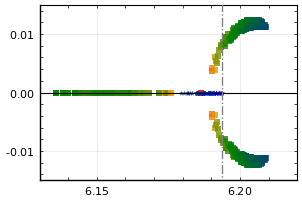

In [14]:
scatter(real.(pole3), imag.(pole3),zcolor=abs.(res_df_2c.rs3),m = (:circle,:rainbow, 0.8, Plots.stroke(0, :green)),label=false,size=(300,200),legend=false)
scatter!(real.(pole3), -imag.(pole3),zcolor=abs.(res_df_2c.rs3),m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)),label=false  )
scatter!(real.(lower), imag.(lower), zcolor=abs.(res_df_2c.rs2_low),m = (:rect,:rainbow, 0.8,Plots.stroke(0, :green)),label=false,  alpha=0.8 )
scatter!(real.(lower), -imag.(lower),zcolor=abs.(res_df_2c.rs2_low),m = (:rect,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label=false  )
scatter!(real.(higher), imag.(higher), zcolor=abs.(res_df_2c[real.(polesdf_2c.pole_rs2_high) .>6.25,3]),m = (:cross,:rainbow, 0.8,Plots.stroke(0, :green)), label=false  )   
scatter!(real.(higher), -imag.(higher), zcolor=abs.(res_df_2c[real.(polesdf_2c.pole_rs2_high) .>6.25,3]),m = (:cross,:rainbow, 0.8,Plots.stroke(0, :green)),label=false )
scatter!(real.(pole1), imag.(pole1), zcolor=abs.(res_df_2c[res_df_2c.rs1.>0,1]),m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)), label=false, alpha=0.8, marker="*" )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp], c = "gray",linestyle=:dashdot,label=false)
xlims!((6.13,6.22));ylims!((-0.015,0.015))
xticks!([6.15,6.20]);yticks!([-0.01,0.00,0.01])
savefig("poles_residue_2c_inner.pdf")

### 3-channel

In [15]:
using LinearAlgebra, StaticArrays

In [16]:
# preallocating memory to achieve allocation-free code for the T matrix
const cmatrix3 = zeros(ComplexF64, 3, 3);
const vmatrix3 = zeros(Float64, 3, 3);

In [17]:
# construct V and G matrices using StaticArrays to achieve allocation-free code
function vmatrix!(vm, par)
    vm[1,1], vm[2,1], vm[3,1], vm[2,2], vm[3,2], vm[3,3] = par
    vm[1,1] *= 4mjψ^2
    vm[2,1] *= 4mjψ*sqrt(mjψ*mψp)
    vm[3,1] *= 4mjψ*sqrt(mjψ*mψ3770)
    vm[2,2] *= 4mjψ*mψp
    vm[2,3] *= 4mjψ*sqrt(mψp*mψ3770)
    vm[3,3] *= 4mjψ*mψ3770
    vm[1,2] = vm[2,1]; vm[1,3] = vm[3,1]; vm[2,3] = vm[3,2]
    return SMatrix{3,3}(vm)
end

function gmatrix!(gm, w; rs=111)

    gm[1,1] = Gdr(w, mjψ, mjψ)
    gm[2,2] = Gdr(w, mψp, mjψ)
    gm[3,3] = Gdr(w, mψ3770, mjψ)
    
    if rs == 111
        nothing
    elseif rs == 211
        gm[1,1] += 2im *ρ(w,mjψ,mjψ)
    elseif rs == 221
        gm[1,1] += 2im *ρ(w,mjψ,mjψ)
        gm[2,2] += 2im *ρ(w,mψp,mjψ)
    elseif rs == 222
        gm[1,1] += 2im *ρ(w,mjψ,mjψ)
        gm[2,2] += 2im *ρ(w,mψp,mjψ)
        gm[3,3] += 2im *ρ(w,mψ3770,mjψ)
    else
        error("rs should be 111, 211, 221 or 222.")
    end
    return SMatrix{3,3}(gm)
end

function tmatrix(w, par; rs=111)
    vm = vmatrix!(vmatrix3, par)
    gm = gmatrix!(cmatrix3, w, rs=rs)
    return vm * inv(I - gm * vm)
end

function detden(w, par; rs=111)
    vm = vmatrix!(vmatrix3, par)
    gm = gmatrix!(cmatrix3, w, rs=rs)
    return det(I - gm * vm)
end

detden (generic function with 1 method)

In [18]:
parametersets_3c = DataFrame!(CSV.File("data/parametersets_3c.csv"))
parametersets_3c_fit2 = DataFrame!(CSV.File("data/parametersets_3c_fit2.csv"))

polesdf_3c = read_file("data/poles_3c.csv", cols=(:pole_rs111, :pole_rs211_low, :pole_rs211_high, :pole_rs221, :pole_rs222));
polesdf_3c_fit2 = read_file("data/poles_3c_fit2.csv", cols=(:pole_rs111, :pole_rs211_low, :pole_rs211_high, :pole_rs221, :pole_rs222));

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = read_file(::String; cols::NTuple{5,Symbol}) at In[6]:5
└ @ Main .\In[6]:5
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = read_file(::String; cols::NTuple{5,Symbol}) at In[6]:5
└ @ Main .\In[6]:5


In [19]:
res_df_3c= DataFrame(rs111=Real[], rs211_low=Real[], rs211_high=Real[], rs221=Real[],rs222=Real[]) 
res_df_3c_fit2= DataFrame(rs111=Real[], rs211_low=Real[], rs211_high=Real[], rs221=Real[],rs222=Real[])
for i=1:nrow(parametersets_3c)
    restem=Vector(undef,5)
    rss=(111,211,211,221,222)
    for j=1:5
        #different Riemann sheets
        w0=polesdf_3c[i,j]
        resfun(w)=sqrt(abs(tmatrix(w,parametersets_3c[i,2:7];rs=rss[j])[1]*(w^2-w0^2)))
        res7=resfun(w0-10E-7)
        res8=resfun(w0-10E-8)
        #shows the residue and relative error between 10E-8 and 10E-7
        restem[j]= res8
    end
    push!(res_df_3c, restem)
end  

for i=1:nrow(parametersets_3c_fit2)
    restem=Vector(undef,5)
    rss=(111,211,211,221,222)
    for j=1:5
        #different Riemann sheets
        w0=polesdf_3c_fit2[i,j]
        resfun(w)=sqrt(abs(tmatrix(w,parametersets_3c_fit2[i,2:7];rs=rss[j])[1]*(w^2-w0^2)))
        res7=resfun(w0-10E-7)
        res8=resfun(w0-10E-8)
        #shows the residue and relative error between 10E-8 and 10E-7
        restem[j]= res8
    end
    push!(res_df_3c_fit2, restem)
end 

In [20]:
pole1 = polesdf_3c[(real.(polesdf_3c.pole_rs111)) .>0, 1]
    pole211 = polesdf_3c[real.(polesdf_3c.pole_rs211_low).>0, 2]
    pole211high = polesdf_3c[real.(polesdf_3c.pole_rs211_high) .>0, 3]
    
    pole1_fit2 = polesdf_3c_fit2[(real.(polesdf_3c_fit2.pole_rs111)) .>0, 1]
    pole211_fit2 = polesdf_3c_fit2[real.(polesdf_3c_fit2.pole_rs211_low).>0, 2]
    pole211high_fit2 = polesdf_3c_fit2[real.(polesdf_3c_fit2.pole_rs211_high) .>0, 3]
    
    res1 = res_df_3c[(real.(polesdf_3c.pole_rs111)) .>0, 1]
    res211 = res_df_3c[real.(polesdf_3c.pole_rs211_low).>0, 2]
    res211high =res_df_3c[real.(polesdf_3c.pole_rs211_high) .>0, 3]
    
    res1_fit2 = res_df_3c_fit2[(real.(polesdf_3c_fit2.pole_rs111)) .>0, 1]
    res211_fit2 =res_df_3c_fit2[real.(polesdf_3c_fit2.pole_rs211_low).>0, 2]
    res211high_fit2 =res_df_3c_fit2[real.(polesdf_3c_fit2.pole_rs211_high) .>0, 3];

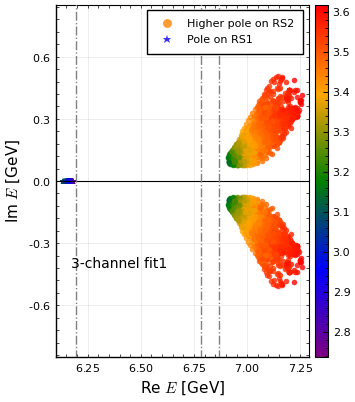

In [21]:
# scatter(real.(pole211), imag.(pole211),zcolor=res211,m = (:circle,:rainbow, 0.8, Plots.stroke(0, :green)), label="Lower pole on RS2", alpha=0.8)
scatter(real.(pole211high), imag.(pole211high), zcolor=log.(res211high),m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)),label="Higher pole on RS2", alpha=0.8,size=(350,400) )
scatter!(real.(pole211high), -imag.(pole211high), zcolor=log.(res211high),m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)), label=false, alpha=0.8 )
scatter!(real.(pole1), imag.(pole1),zcolor=log.(res1),m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label="Pole on RS1"  )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp,mjψ+mψ3770], c = "gray",linestyle=:dashdot,label=false)
xlabel!("Re "*L"E"*" [GeV]"); ylabel!("Im "*L"E"*" [GeV]")
annotate!([(6.4,-0.4,Plots.text("3-channel fit1",10))])
xlims!((6.1,7.29));ylims!((-0.85,0.85))
savefig("poles_residue_3c_log.pdf")

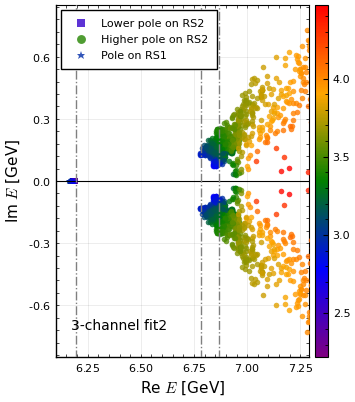

In [22]:
scatter(real.(pole211_fit2), imag.(pole211_fit2),zcolor=log.(res211_fit2),m = (:rect,:rainbow, 0.8, Plots.stroke(0, :green)), label="Lower pole on RS2", alpha=0.8,size=(350,400))
scatter!(real.(pole211high_fit2), imag.(pole211high_fit2), zcolor=log.(res211high_fit2),m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)), label="Higher pole on RS2", alpha=0.8 )
scatter!(real.(pole211high_fit2), -imag.(pole211high_fit2), zcolor=log.(res211high_fit2),m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)), label=false, alpha=0.8 )
scatter!(real.(pole1_fit2), imag.(pole1_fit2),zcolor=log.(res1_fit2),m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label="Pole on RS1"  )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp,mjψ+mψ3770], c = "gray",linestyle=:dashdot,label=false)
xlabel!("Re "*L"E"*" [GeV]"); ylabel!("Im "*L"E"*" [GeV]")
annotate!([(6.4,-0.7,Plots.text("3-channel fit2",10))])
xlims!((6.1,7.29));ylims!((-0.85,0.85))
savefig("poles_residue_3c_fit2_log.pdf")

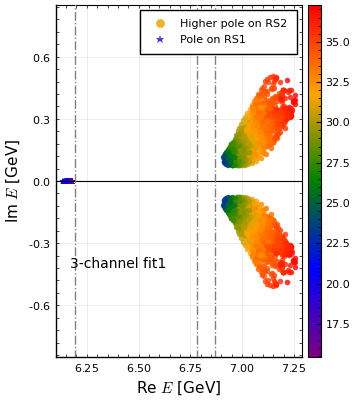

In [23]:
# scatter(real.(pole211), imag.(pole211),zcolor=res211,m = (:circle,:rainbow, 0.8, Plots.stroke(0, :green)), label="Lower pole on RS2", alpha=0.8)
scatter(real.(pole211high), imag.(pole211high), zcolor=res211high,m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)),label="Higher pole on RS2", alpha=0.8,size=(350,400) )
scatter!(real.(pole211high), -imag.(pole211high), zcolor=res211high,m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)), label=false, alpha=0.8 )
scatter!(real.(pole1), imag.(pole1),zcolor=res1,m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label="Pole on RS1"  )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp,mjψ+mψ3770], c = "gray",linestyle=:dashdot,label=false)
xlabel!("Re "*L"E"*" [GeV]"); ylabel!("Im "*L"E"*" [GeV]")
annotate!([(6.4,-0.4,Plots.text("3-channel fit1",10))])
xlims!((6.1,7.29));ylims!((-0.85,0.85))
savefig("poles_residue_3c.pdf")

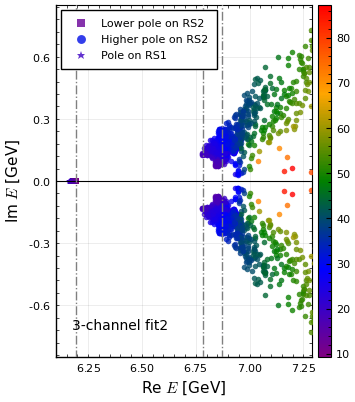

In [24]:
scatter(real.(pole211_fit2), imag.(pole211_fit2),zcolor=res211_fit2,m = (:rect,:rainbow, 0.8, Plots.stroke(0, :green)), label="Lower pole on RS2", alpha=0.8,size=(350,400))
scatter!(real.(pole211high_fit2), imag.(pole211high_fit2), zcolor=res211high_fit2,m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)), label="Higher pole on RS2", alpha=0.8 )
scatter!(real.(pole211high_fit2), -imag.(pole211high_fit2), zcolor=res211high_fit2,m = (:circle,:rainbow, 0.8,Plots.stroke(0, :green)), label=false, alpha=0.8 )
scatter!(real.(pole1_fit2), imag.(pole1_fit2),zcolor=res1_fit2,m = (:star5,:rainbow, 0.8,Plots.stroke(0, :green)),  alpha=0.8,label="Pole on RS1"  )
hline!([0], color=:black, lw=0.8,label=false)
vline!([2*mjψ,mjψ+mψp,mjψ+mψ3770], c = "gray",linestyle=:dashdot,label=false)
xlabel!("Re "*L"E"*" [GeV]"); ylabel!("Im "*L"E"*" [GeV]")
annotate!([(6.4,-0.7,Plots.text("3-channel fit2",10))])
xlims!((6.1,7.29));ylims!((-0.85,0.85))
savefig("poles_residue_3c_fit2.pdf")